# Libraries

In [2]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


# Loading the Files

Download the csv files into the `data/` directory.

Columns in trainingSet: Index(['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'Score'],
      dtype='object')
Columns in testingSet: Index(['Id', 'Score'], dtype='object')
Columns in trainingSet after loading: Index(['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'Score'],
      dtype='object')
Columns in testingSet after loading: Index(['Id', 'Score'], dtype='object')
train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0    

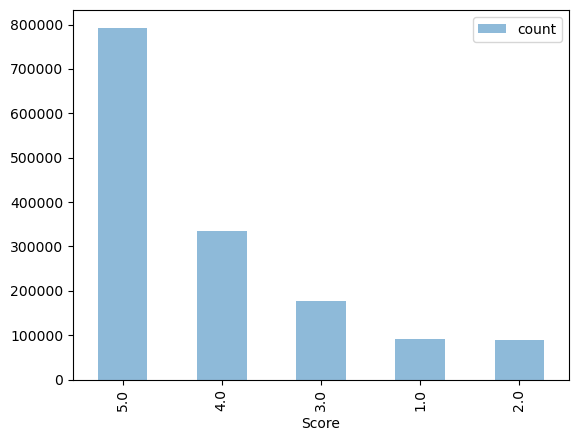


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [4]:
# don't use the average score of the product, as these are the data you shouldn't have access to
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

# # Debug: Check loaded columns to confirm required columns are present
# print("Columns in trainingSet:", trainingSet.columns)
# print("Columns in testingSet:", testingSet.columns)
# ###
# # Debug: Check loaded columns
# print("Columns in trainingSet after loading:", trainingSet.columns)
# print("Columns in testingSet after loading:", testingSet.columns)
# ####

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape) # all the IDs you need to make predictions for

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [6]:
def add_features_to(df):
    # Debug: Check columns in the input DataFrame
    # print("Columns in df at the start of add_features_to:", df.columns)

    # Only perform Helpfulness calculations if the required columns are present
    if 'HelpfulnessNumerator' in df.columns and 'HelpfulnessDenominator' in df.columns:
        df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
        df['Helpfulness'] = df['Helpfulness'].fillna(0)  # Fill NaN with 0 where Denominator is 0
    else:
        print("Warning: 'HelpfulnessNumerator' or 'HelpfulnessDenominator' is missing.")
        df['Helpfulness'] = 0  # Placeholder if columns are missing

    # Text Length
    df['Text_Length'] = df['Text'].apply(lambda x: len(str(x))) if 'Text' in df.columns else 0
    
    # Summary Length
    df['Summary_Length'] = df['Summary'].apply(lambda x: len(str(x))) if 'Summary' in df.columns else 0
    
    # Word Count in Text
    df['Word_Count'] = df['Text'].apply(lambda x: len(str(x).split())) if 'Text' in df.columns else 0
    
    # Average Word Length in Text
    df['Avg_Word_Length'] = (
        df['Text'].apply(lambda x: sum(len(word) for word in str(x).split()) / (len(str(x).split()) + 1e-5))
        if 'Text' in df.columns else 0
    )

    # Sentiment Analysis for Text and Summary (using TextBlob)
    try:
        from textblob import TextBlob
        df['Text_Sentiment'] = (
            df['Text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity) if 'Text' in df.columns else 0
        )
        df['Summary_Sentiment'] = (
            df['Summary'].apply(lambda x: TextBlob(str(x)).sentiment.polarity) if 'Summary' in df.columns else 0
        )
    except ImportError:
        print("TextBlob not installed; skipping sentiment features.")
        df['Text_Sentiment'] = 0
        df['Summary_Sentiment'] = 0

    # Helpfulness Vote Count
    df['Helpfulness_Vote_Count'] = df['HelpfulnessDenominator'] if 'HelpfulnessDenominator' in df.columns else 0
    
    # Year and Month from Timestamp
    if 'Time' in df.columns:
        df['Review_Date'] = pd.to_datetime(df['Time'], unit='s')
        df['Review_Year'] = df['Review_Date'].dt.year
        df['Review_Month'] = df['Review_Date'].dt.month
        df.drop(columns=['Review_Date'], inplace=True)
    else:
        df['Review_Year'] = 0
        df['Review_Month'] = 0

    # Product and User Mean Score
    if 'Score' in df.columns and 'ProductId' in df.columns and 'UserId' in df.columns:
        product_mean_score = df.groupby('ProductId')['Score'].transform('mean')
        user_mean_score = df.groupby('UserId')['Score'].transform('mean')
        df['Product_Mean_Score'] = product_mean_score
        df['User_Mean_Score'] = user_mean_score
    else:
        # For test set, we assume the mean scores are calculated beforehand
        df['Product_Mean_Score'] = 0  # Placeholder, or load from pre-computed values
        df['User_Mean_Score'] = 0     # Placeholder, or load from pre-computed values

    return df

# Sample + Split into training and testing set

In [8]:
from sklearn.model_selection import train_test_split

# Apply feature engineering to create X_train_full
X_train_full = add_features_to(trainingSet)

# Check if X_train_full is created successfully
print("Columns in X_train_full after feature engineering:", X_train_full.columns)

# Drop 'Score' from X_train_full for the split and use Y_train as the target variable
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train_full.drop(columns=['Score']),
    X_train_full['Score'],
    test_size=1/4.0,
    random_state=0
)

Columns in df at the start of add_features_to: Index(['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'Score'],
      dtype='object')
TextBlob not installed; skipping sentiment features.
Columns in X_train_full after feature engineering: Index(['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'Score',
       'Helpfulness', 'Text_Length', 'Summary_Length', 'Word_Count',
       'Avg_Word_Length', 'Text_Sentiment', 'Summary_Sentiment',
       'Helpfulness_Vote_Count', 'Review_Year', 'Review_Month',
       'Product_Mean_Score', 'User_Mean_Score'],
      dtype='object')


# Feature Selection

In [10]:
# Apply feature engineering to training and testing sets
X_train_full = add_features_to(trainingSet)
X_submission = add_features_to(testingSet)

# Target variable
Y_train = X_train_full['Score']
X_train_full = X_train_full.drop(columns=['Score'])

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train_full, Y_train, test_size=1/4.0, random_state=0
)

# Define the desired features
features = [
    'Helpfulness', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
    'Text_Length', 'Summary_Length', 'Word_Count', 'Avg_Word_Length',
    'Text_Sentiment', 'Summary_Sentiment', 'Helpfulness_Vote_Count',
    'Review_Year', 'Review_Month', 'Product_Mean_Score', 'User_Mean_Score'
]

# Calculate the intersection of features and available columns for each dataset
train_features = list(set(features) & set(X_train.columns))
test_features = list(set(features) & set(X_test.columns))
submission_features = list(set(features) & set(X_submission.columns))

# Debug: Verify the selected features and available columns
print("Train features selected:", train_features)
print("Test features selected:", test_features)
print("Submission features selected:", submission_features)

# Select these features from the datasets
X_train_select = X_train[train_features]
X_test_select = X_test[test_features]
X_submission_select = X_submission[submission_features]

Columns in df at the start of add_features_to: Index(['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'Score',
       'Helpfulness', 'Text_Length', 'Summary_Length', 'Word_Count',
       'Avg_Word_Length', 'Text_Sentiment', 'Summary_Sentiment',
       'Helpfulness_Vote_Count', 'Review_Year', 'Review_Month',
       'Product_Mean_Score', 'User_Mean_Score'],
      dtype='object')
TextBlob not installed; skipping sentiment features.
Columns in df at the start of add_features_to: Index(['Id', 'Score'], dtype='object')
TextBlob not installed; skipping sentiment features.
Train features selected: ['Review_Month', 'HelpfulnessNumerator', 'Word_Count', 'Summary_Length', 'Text_Length', 'User_Mean_Score', 'Text_Sentiment', 'Avg_Word_Length', 'Summary_Sentiment', 'Helpfulness', 'HelpfulnessDenominator', 'Helpfulness_Vote_Count', 'Product_Mean_Score', 'Review_Year']
Test features selected: ['Review_Month', 'HelpfulnessNumerator', 'Wor

# Model Creation

In [12]:
# Apply feature engineering to training and testing sets
X_train_full = add_features_to(trainingSet)
X_submission = add_features_to(testingSet)

# Remove rows with NaN in 'Score' from X_train_full and Y_train
X_train_full = X_train_full.dropna(subset=['Score'])
Y_train = X_train_full['Score']
X_train_full = X_train_full.drop(columns=['Score'])

# Split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train_full, Y_train, test_size=1/4.0, random_state=0
)

# Select only numeric columns for scaling and imputation
X_train_numeric = X_train.select_dtypes(include=['float64', 'int64'])
X_test_numeric = X_test.select_dtypes(include=['float64', 'int64'])

# Impute missing values in the feature data and scale
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Fill missing values with column mean
    ('scaler', StandardScaler())                  # Scale features
])

X_train_scaled = preprocessor.fit_transform(X_train_numeric)
X_test_scaled = preprocessor.transform(X_test_numeric)

# Create and train the KNeighborsClassifier model
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train_scaled, Y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test_scaled)

Columns in df at the start of add_features_to: Index(['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'Score',
       'Helpfulness', 'Text_Length', 'Summary_Length', 'Word_Count',
       'Avg_Word_Length', 'Text_Sentiment', 'Summary_Sentiment',
       'Helpfulness_Vote_Count', 'Review_Year', 'Review_Month',
       'Product_Mean_Score', 'User_Mean_Score'],
      dtype='object')
TextBlob not installed; skipping sentiment features.
Columns in df at the start of add_features_to: Index(['Id', 'Score', 'Helpfulness', 'Text_Length', 'Summary_Length',
       'Word_Count', 'Avg_Word_Length', 'Text_Sentiment', 'Summary_Sentiment',
       'Helpfulness_Vote_Count', 'Review_Year', 'Review_Month',
       'Product_Mean_Score', 'User_Mean_Score'],
      dtype='object')
TextBlob not installed; skipping sentiment features.


# Model Evaluation

Accuracy on testing set =  0.5310177305728505


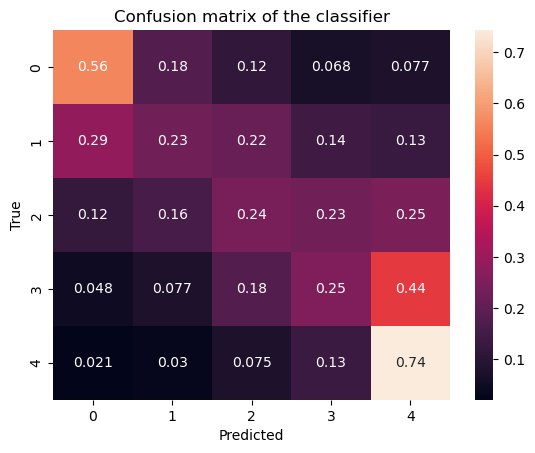

In [14]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [16]:
# Create the submission file
# Define the features to use consistently (excluding 'Id' and 'Time')
features = [
    'Helpfulness', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
    'Text_Length', 'Summary_Length', 'Word_Count', 'Avg_Word_Length',
    'Text_Sentiment', 'Summary_Sentiment', 'Helpfulness_Vote_Count',
    'Review_Year', 'Review_Month', 'Product_Mean_Score', 'User_Mean_Score'
]

# Apply feature engineering to training and testing sets
X_train_full = add_features_to(trainingSet)
X_submission = add_features_to(testingSet)

# Drop any rows with NaN values in 'Score' column in X_train_full
X_train_full = X_train_full.dropna(subset=['Score'])
Y_train = X_train_full['Score']
X_train_full = X_train_full.drop(columns=['Score'])

# Split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train_full[features], Y_train, test_size=1/4.0, random_state=0
)

# Impute missing values in the feature data and scale
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Fill missing values with column mean
    ('scaler', StandardScaler())                  # Scale features
])

X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

# Train the model
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train_scaled, Y_train)

# Predict the test set
Y_test_predictions = model.predict(X_test_scaled)

# Ensure X_submission_select has consistent feature columns
X_submission_select = X_submission.reindex(columns=features, fill_value=0)

# Transform the submission data using the previously fitted preprocessor
X_submission_scaled = preprocessor.transform(X_submission_select)

# Predict the Score for the submission data
Y_submission_predictions = model.predict(X_submission_scaled)

# Create the submission DataFrame with the required format
submission_df = pd.DataFrame({
    'Id': X_submission['Id'],  # Ensure 'Id' is included from X_submission
    'Score': Y_submission_predictions
})

# Save the submission DataFrame as a CSV file
submission_df.to_csv("./data/submission.csv", index=False)

Columns in df at the start of add_features_to: Index(['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'Score',
       'Helpfulness', 'Text_Length', 'Summary_Length', 'Word_Count',
       'Avg_Word_Length', 'Text_Sentiment', 'Summary_Sentiment',
       'Helpfulness_Vote_Count', 'Review_Year', 'Review_Month',
       'Product_Mean_Score', 'User_Mean_Score'],
      dtype='object')
TextBlob not installed; skipping sentiment features.
Columns in df at the start of add_features_to: Index(['Id', 'Score', 'Helpfulness', 'Text_Length', 'Summary_Length',
       'Word_Count', 'Avg_Word_Length', 'Text_Sentiment', 'Summary_Sentiment',
       'Helpfulness_Vote_Count', 'Review_Year', 'Review_Month',
       'Product_Mean_Score', 'User_Mean_Score'],
      dtype='object')
TextBlob not installed; skipping sentiment features.
